<a href="https://colab.research.google.com/github/thompson005/Rejen_thompson/blob/main/Malware_Detector_Random_Forest_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import gc

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

import os


In [ ]:
train_df = pd.read_csv('deep-learning-for-cyber-security/train.csv')
test_df = pd.read_csv('deep-learning-for-cyber-security/test.csv')

In [ ]:
train_df['Malicious'] = train_df['Malicious'].map({False:0, True:1})
train_df.head(5)

,READ_EXTERNAL_STORAGE,RECEIVE_BOOT_COMPLETED,WRITE_CONTACTS,RECORD_AUDIO,ACCESS_CACHE_FILESYSTEM,RECEIVE,BILLING,READ,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_FINE_LOCATION,...,CHANGE_WIFI_STATE,MODIFY_AUDIO_SETTINGS,BLUETOOTH_ADMIN,RECEIVE_SMS,ACCESS_MTK_MMHW,UNINSTALL_SHORTCUT,READ_INTERNAL_STORAGE,ACCESS_COARSE_LOCATION,Malicious,id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7032
1,0,1,0,0,0,0,0,0,1,0,...,1,1,0,1,0,0,0,0,1,11026
2,0,0,0,0,0,0,0,0,1,1,...,0,1,0,1,0,0,0,1,1,9772
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,844
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,1,14630


In [ ]:
TARGET = ['Malicious']
x = train_df.drop(columns=['Malicious'])
y = train_df[TARGET]

In [ ]:
# Seed all
seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
gc.collect()

14243

# Parameter tuning with GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [140],
    'max_depth' : [22]
}
model = RandomForestClassifier(random_state=seed)

CV = GridSearchCV(model,param_grid, cv=10, n_jobs= 1)

CV.fit(x, np.ravel(y))
print(CV.best_params_)
print(CV.best_score_)

{'max_depth': 22, 'n_estimators': 140}
0.9720563494793458


# KFOLD=10 Cross validation with best seeds

In [ ]:
predTest = pd.DataFrame(0, index=np.arange(test_df.shape[0]), columns=TARGET)
predTrain = y[TARGET].copy()

#for seed in random.sample(range(300, 400), 20):
for seed in [15,54,68,79,105,134,189,220,234,281,357,363]:
    FOLDS = 10
    kf = StratifiedKFold(n_splits=FOLDS,shuffle = True, random_state=seed)

    model = RandomForestClassifier(n_estimators=140, max_depth=22, random_state=seed)

    scores = []

    fold_num = 0
    for train_index, test_index in kf.split(x,y):
        fold_num += 1
        X_train = x.iloc[train_index]
        y_train = y.iloc[train_index]
        X_val = x.loc[test_index]
        y_val = y.loc[test_index]

        model.fit(X_train,np.ravel(y_train))
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val,y_pred)
        scores.append(acc)
        print("Fold ",fold_num," Accuracy = ",acc)

        # OOF prediction
        oof_pred = model.predict(x)
        predTrain.loc[:,"Malicious"] += oof_pred

        # Test prediction
        test_pred = model.predict(test_df)
#        predTest.loc[:,f'{fold_num}_{seed}'] = test_pred
        predTest.loc[:,"Malicious"] += test_pred

    print(f"SEED{seed} CV Accuracy = ",np.mean(scores)," + ",np.std(scores))

Fold  1  Accuracy =  0.9664310954063604
Fold  2  Accuracy =  0.9628975265017667
Fold  3  Accuracy =  0.9770318021201413
Fold  4  Accuracy =  0.9628975265017667
Fold  5  Accuracy =  0.9805309734513274
Fold  6  Accuracy =  0.9769911504424779
Fold  7  Accuracy =  0.9769911504424779
Fold  8  Accuracy =  0.9716814159292035
Fold  9  Accuracy =  0.9734513274336283
Fold  10  Accuracy =  0.984070796460177
SEED15 CV Accuracy =  0.9732974764689327  +  0.006897245642037061
Fold  1  Accuracy =  0.9734982332155477
Fold  2  Accuracy =  0.9770318021201413
Fold  3  Accuracy =  0.9717314487632509
Fold  4  Accuracy =  0.9646643109540636
Fold  5  Accuracy =  0.9699115044247788
Fold  6  Accuracy =  0.9752212389380531
Fold  7  Accuracy =  0.9734513274336283
Fold  8  Accuracy =  0.9734513274336283
Fold  9  Accuracy =  0.9752212389380531
Fold  10  Accuracy =  0.9752212389380531
SEED54 CV Accuracy =  0.9729403671159197  +  0.00335125264726248
Fold  1  Accuracy =  0.9752650176678446
Fold  2  Accuracy =  0.96466

In [ ]:
predTest.loc[predTest["Malicious"]<61,'Malicious'] = 0
predTest.loc[predTest["Malicious"]>60,'Malicious'] = 1

In [ ]:
predTest['Malicious'].value_counts()

Malicious
0    1215
1    1209
Name: count, dtype: int64

# Feature importance

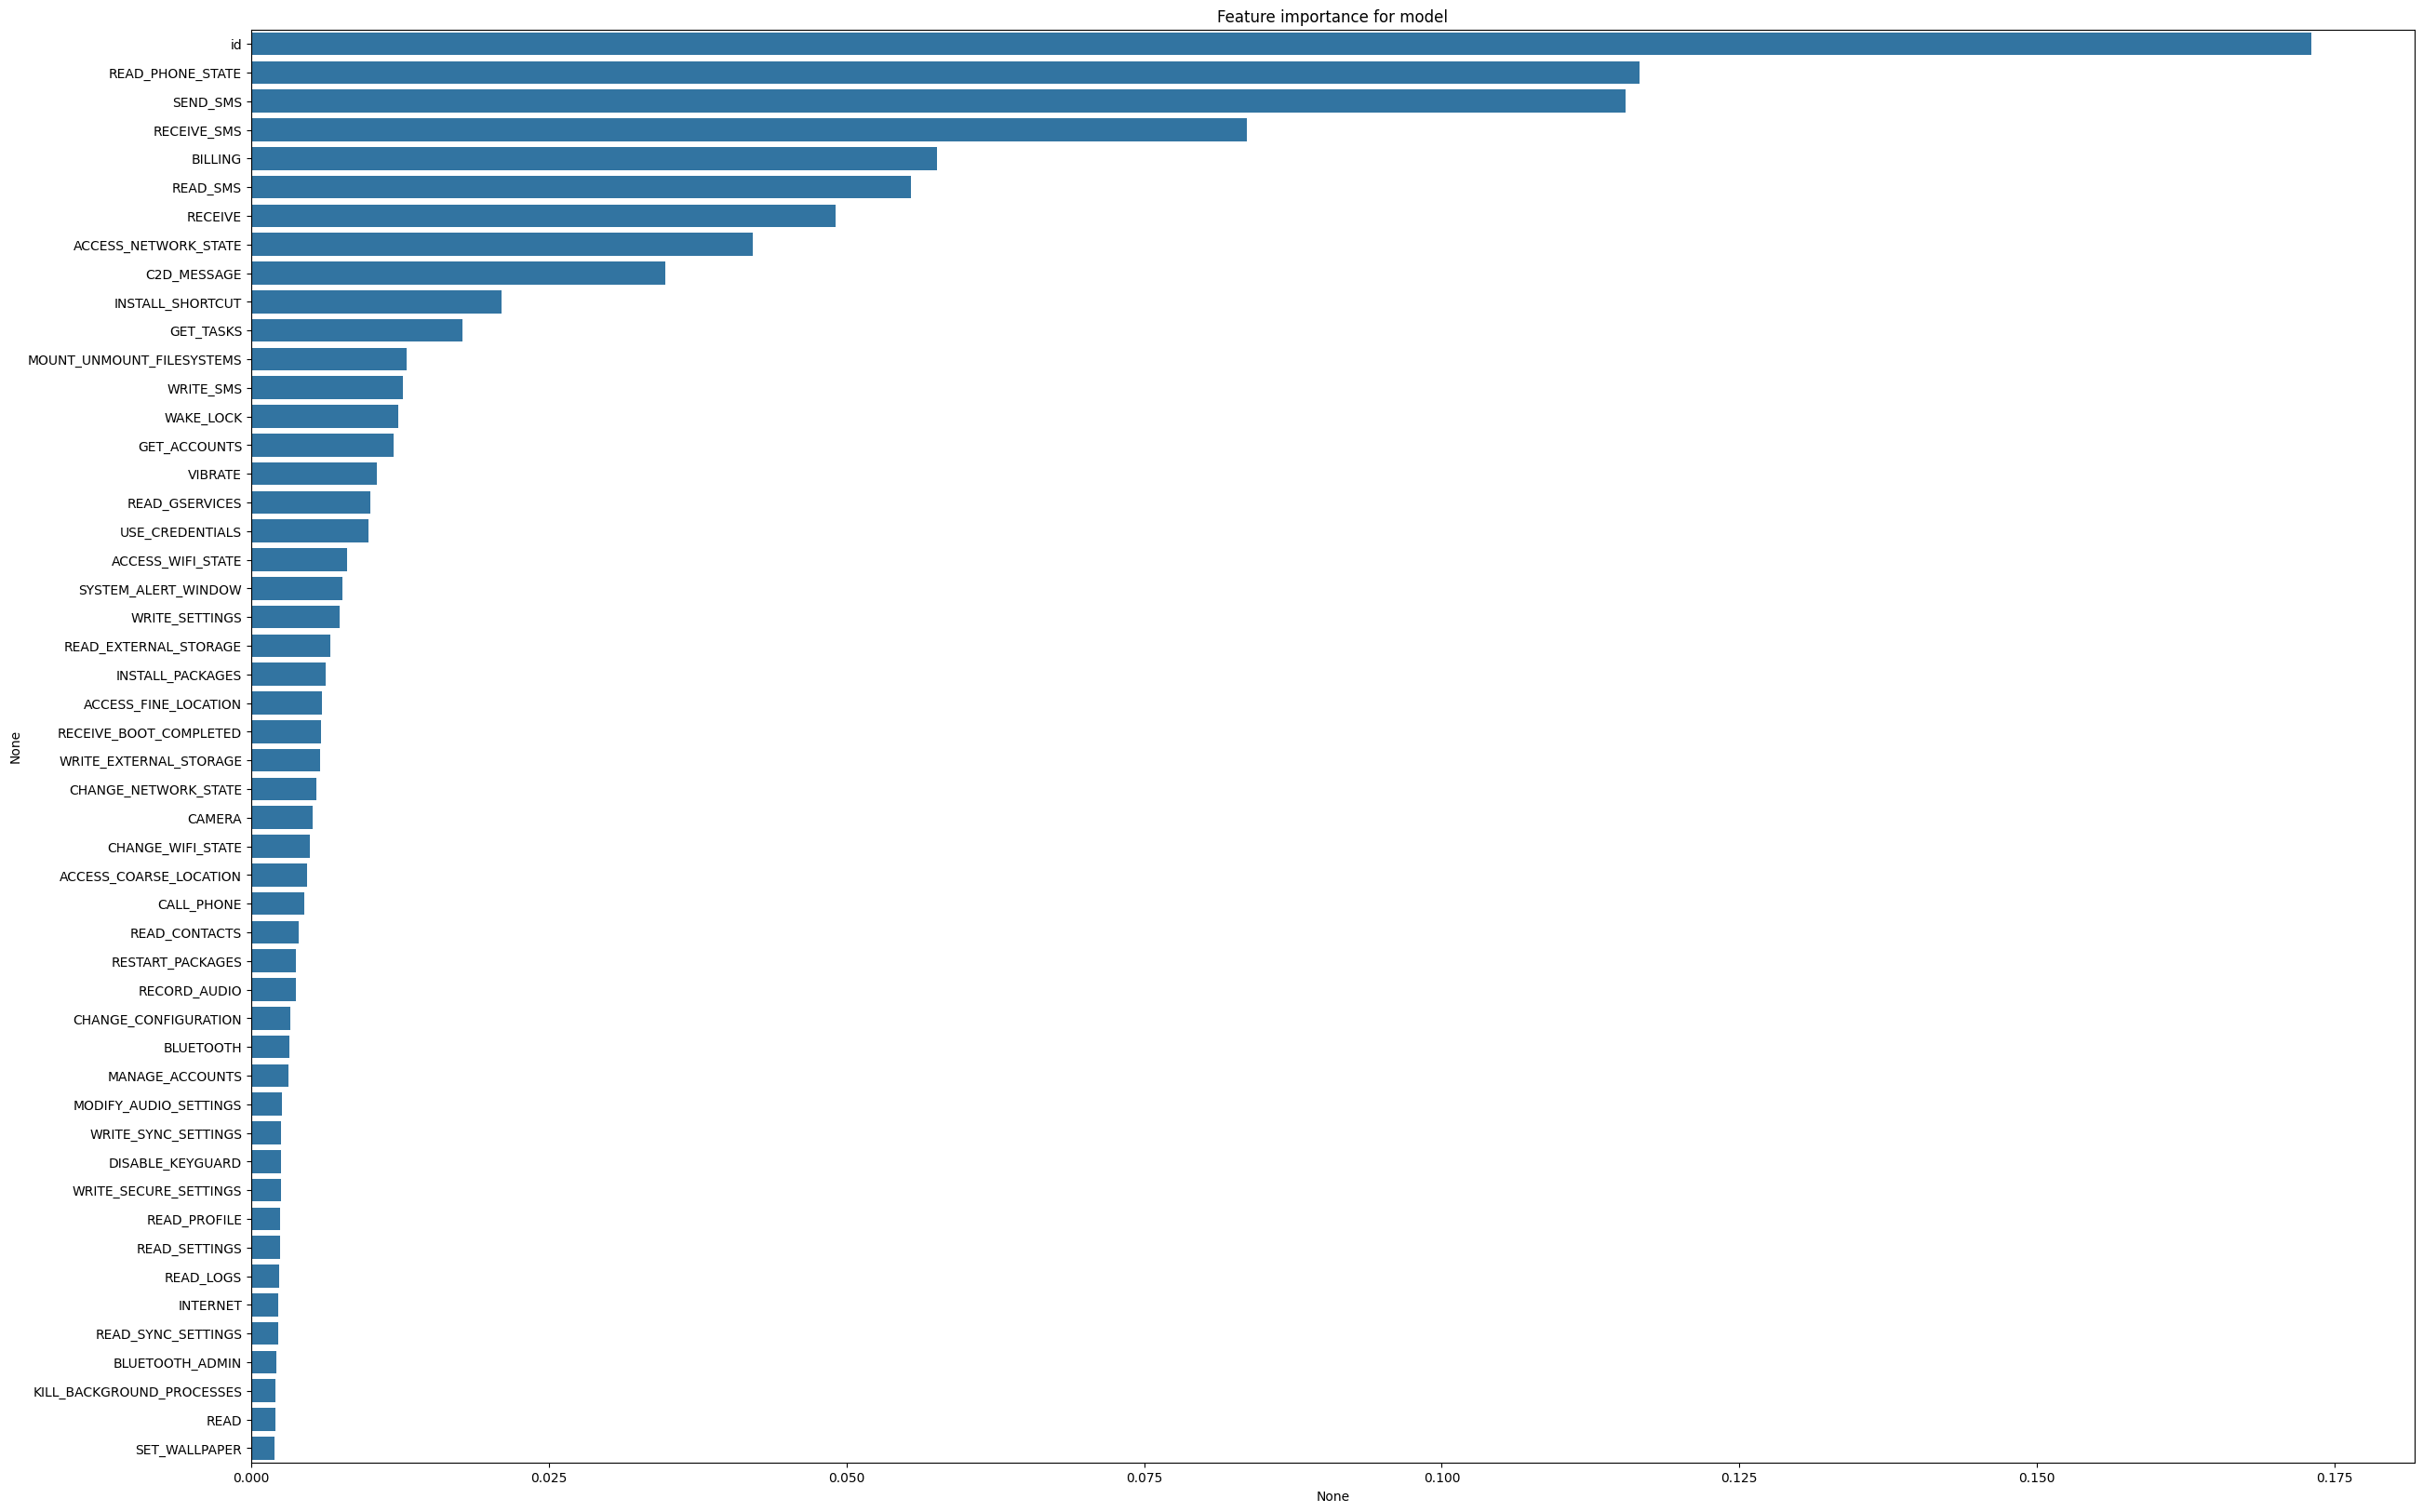

In [ ]:
import matplotlib.pyplot as plt # plotting
import seaborn as sns # visualisation

feature_imp = pd.Series(CV.best_estimator_.feature_importances_,index=CV.best_estimator_.feature_names_in_).sort_values(ascending=False)
f,ax = plt.subplots(figsize=(30,20))
ax = sns.barplot(x=feature_imp[:50], y=feature_imp[:50].index)
ax.set_title('Feature importance for model')
plt.show()

# Final Prediction

In [ ]:
prediction = predTest['Malicious']
submitData = pd.read_csv('deep-learning-for-cyber-security\test.csv')
output = pd.DataFrame({'id': submitData.id,
                       'Malicious': prediction})
output['Malicious'] = output['Malicious'].map({0:False, 1:True})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
output.head(5)

Your submission was successfully saved!


,id,Malicious
0,2824.0,False
1,5506.0,True
2,4657.0,False
3,2679.0,True
4,7912.0,False
